# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Grouping job ads into categories 
* Monitoring communications (Email - State Department, Google) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how an LDA Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel


import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Part 1: Describe how an LDA Model works

We are going to focus on a high level of understand for how LDA works, meaning we are going to focus on "what it does" instead of "how it does it". I realize that this may be unsatisfying to some so I've included some resources that serve as a prerequisite for understanding how LDA works at a mathematical level. 

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

PGM are represented by a graph that expresses the conditional dependence structure between random variables. Here's the LDA representation dependency graph: 

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

These image is communicating the hierarchical dependency between probability distributions and their parameters. This is an application of Bayesian Probability - on steroids. 


In order to understand how LDA works, one must first understand how PGM work. If this is something that you're interested in learning more about here are some resources: 

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is call [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) The cool thing about this repo is that each chapter has the same material covered in several notebooks but each notebook is written in a different python package: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can even learn a new library if you want or stick to what you know. 

Having said that, [**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning. 

### Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) Here's a medium article that works through an example of LDA. This is useful if you'd like to get an exposure of LDA outside of this notebook.

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/)This is an interactive data visualization tool that allows us to explore a simple and visual example of LDA. We'll be using this to learn about LDA in class. 

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) This is an example of implementing LDA using the same dataset that we are using in the guided project.  

# Problem Statement

We are going to load some emails. Those emails do belong to topics however those topics are hierarchical.

    sci
        \_ electronics, space


    talk
        \_politics 
                  \_ guns, middle east
              
So what's the best way to categorize these emails - is it between science and talk? 

Is it between electronics, space, guns, and the Middle East? 

The Middle East is a pretty broad topics in and of itself, should that topic be broken down into further sub-topics?


Let's learn about Topic Modeling and how it can help us answer this questions!

### Load Email Corpus

In [5]:
# notice that the categories are hierarchical
# so there is a sense in which we 2 topics but also as many as 4 topics  
categories = ['sci.electronics', 'sci.space', 
              'talk.politics.guns', 'talk.politics.mideast']
data = fetch_20newsgroups(categories=categories)

In [6]:
# create X and Y from data

###BEGIN SOLUTION
X = data.data
Y = data.target
target_names = data.target_names
###END SOLUTION

In [7]:
# loda data into a dataframe 


data = {
    'content': X,
    'target': Y,
    'target_names': [target_names[target_id] for target_id in Y]
}

df = pd.DataFrame(data=data)

In [8]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().lstrip().rstrip()

In [9]:
# clean our text data and save it to a new column
df["clean_data"] = df["content"].apply(clean_data)

In [10]:
df.head()

,content,target,target_names,clean_data
0,From: webb@itu1 (90-29265 Webber AH)\nSubjec...,0,sci.electronics,webber ah subject re adcom cheap products arti...
1,From: nate@psygate.psych.indiana.edu (Nathan E...,2,talk.politics.guns,nathan engle subject re atf burns dividian ran...
2,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec...",3,talk.politics.mideast,andi beyer subject re israeli terrorism organi...
3,"From: levy@levy.fnal.gov (Mark E. Levy, ext. 8...",0,sci.electronics,mark e levy ext subject sources for intel d c ...
4,From: wolfone@ccwf.cc.utexas.edu (I am an andr...,2,talk.politics.guns,i am an android subject re atf burns dividian ...


### Create Tokens 

Before we can use the Gemsim library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens. 

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [11]:
# we mush initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_lg")

In [13]:
%%time
# create our tokens in the form of lemmas 
df['lemmas'] = df['clean_data'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 1.29 s, sys: 341 ms, total: 1.63 s
Wall time: 19.6 s


### Take a look at our lemmas

In [14]:
# print out the lemmeas from the first article

### Filter out low quality lemmas

In [15]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemmas for lemmas in lemmas if len(lemmas) > 2]

In [16]:
# apply filter_lemmas

### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

In [17]:
# Create Dictionary

# Term Document Frequency

# stores (token id, token count) for each doc in the corpus

# Human readable format of corpus (term-frequency)


### BEGIN SOLUTION
# Create Dictionary
id2word = corpora.Dictionary(df['lemmas'] )

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

# stores (token id, token count) for each doc in the corpus
doc_id = 5
corpus[doc_id]

# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[doc_id]]

### END SOLUTION

[('article', 3),
 ('d', 1),
 ('drop', 1),
 ('good', 1),
 ('hear', 1),
 ('inside', 3),
 ('line', 1),
 ('m', 4),
 ('organization', 1),
 ('people', 2),
 ('point', 1),
 ('post', 1),
 ('product', 1),
 ('s', 4),
 ('subject', 1),
 ('sure', 1),
 ('t', 4),
 ('think', 1),
 ('true', 1),
 ('w', 2),
 ('want', 2),
 ('believe', 1),
 ('child', 2),
 ('come', 3),
 ('distribution', 1),
 ('edu', 4),
 ('fbi', 5),
 ('fire', 1),
 ('get', 3),
 ('host', 1),
 ('nntp', 1),
 ('place', 1),
 ('set', 1),
 ('write', 3),
 ('doubt', 1),
 ('happen', 1),
 ('truth', 2),
 ('c', 2),
 ('com', 5),
 ('day', 4),
 ('j', 1),
 ('news', 2),
 ('r', 1),
 ('stay', 2),
 ('way', 1),
 ('action', 2),
 ('affair', 1),
 ('agree', 2),
 ('alive', 1),
 ('american', 2),
 ('ample', 1),
 ('apparently', 1),
 ('april', 2),
 ('arlen', 1),
 ('arm', 2),
 ('arras', 2),
 ('bastard', 1),
 ('batf', 2),
 ('bill', 2),
 ('bleed', 4),
 ('blind', 1),
 ('bungle', 1),
 ('chatham', 2),
 ('choose', 2),
 ('chopin', 2),
 ('clem', 1),
 ('clinton', 2),
 ('comment', 1),

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [18]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

In [19]:
%%time

num_topics = 2
### This cell runs the multi-processor version of the model (faster)
lda_multicore_2_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

num_topics = 6
### This cell runs the multi-processor version of the model (faster)
lda_multicore_6_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

CPU times: user 7.84 s, sys: 835 ms, total: 8.68 s
Wall time: 9.18 s


In [20]:
from gensim import models
#lda_multicore =  models.LdaModel.load('lda_multicore.model')

# Part 3: Interpret LDA results & Select the appropriate number of topics

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.082782  0.0       1        1  56.767613
1     -0.082782  0.0       2        1  43.232387, topic_info=         Term         Freq        Total Category  logprob  loglift
650     space  1346.000000  1346.000000  Default  30.0000  30.0000
507       gun  1476.000000  1476.000000  Default  29.0000  29.0000
957  armenian  1306.000000  1306.000000  Default  28.0000  28.0000
641      nasa   681.000000   681.000000  Default  27.0000  27.0000
638    launch   459.000000   459.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
170      know   529.389114  1441.079977   Topic2  -5.8580  -0.1628
124      year   434.877880  1005.566168   Topic2  -6.0546   0.0003
153       don   453.605353  1313.418465   Topic2  -6.0125  -0.2246
38       good   387.418097   765.960416   Topic2  -6.1702   0.1570
100     think   395.071608  1204.830579   Topic2  -6.1506  -0.2764

[204 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1148       1  0.033759     alaska
1148       2  0.965501     alaska
1280       1  0.968085  amendment
1280       2  0.028307  amendment
26610      1  0.040586     anania
...      ...       ...        ...
207        2  0.570462       work
208        1  0.533195      write
208        2  0.466838      write
124        1  0.567839       year
124        2  0.432592       year

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.132914  0.008793       1        1  20.588788
0      0.104228 -0.022448       2        1  19.896617
5      0.027189 -0.125747       3        1  18.084580
2     -0.069952 -0.015938       4        1  17.537922
4      0.101582  0.079667       5        1  13.727342
1     -0.030133  0.075673       6        1  10.164751, topic_info=          Term         Freq        Total Category  logprob  loglift
957   armenian  1236.000000  1236.000000  Default  30.0000  30.0000
507        gun  1554.000000  1554.000000  Default  29.0000  29.0000
1006   turkish   675.000000   675.000000  Default  28.0000  28.0000
650      space  1352.000000  1352.000000  Default  27.0000  27.0000
1456    israel   867.000000   867.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
170       know   116.448225  1439.241488   Topic6  -5.9246  -0.2282
124       year   109.615079   991.148660   Topic6  -5.9850   0.0844
309        com   107.418158  1628.185574   Topic6  -6.0053  -0.4322
51        like   104.480330  1368.653019   Topic6  -6.0330  -0.2863
103       time   101.696121  1251.184402   Topic6  -6.0600  -0.2236

[537 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1146      1  0.052274     acad
1146      2  0.017425     acad
1146      4  0.923501     acad
1146      5  0.017425     acad
1512      1  0.598828   access
...     ...       ...      ...
1046      5  0.012699  zoology
1009      2  0.051025     zuma
1009      4  0.012756     zuma
1009      5  0.918455     zuma
1009      6  0.012756     zuma

[1628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 3, 5, 2])

## What is topic coherence?
Topic Coherence measures score a single topic by **measuring the degree of semantic similarity between high scoring words in the topic**. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.


A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is **“the game is a team sport”**, **“the game is played with a ball”**, **“the game demands great physical efforts”**


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=10, step=1)

CPU times: user 47.8 s, sys: 7.71 s, total: 55.5 s
Wall time: 1min 4s


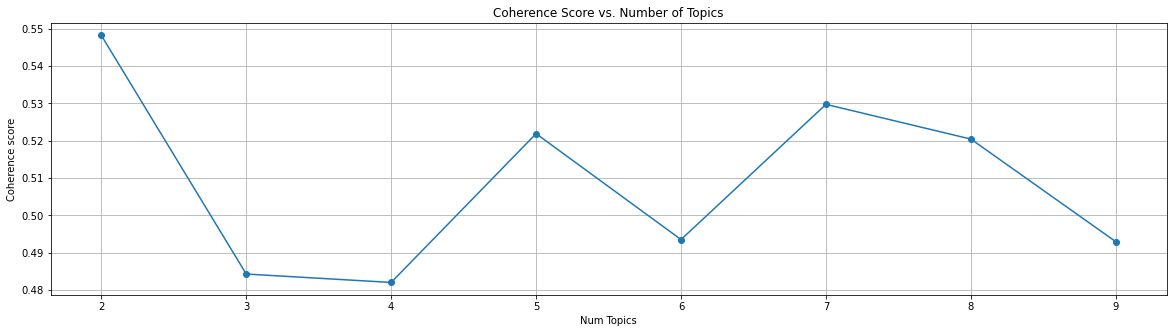

In [28]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

### Index for Model 

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus. 

In [29]:
lda_trained_model = model_list[-2]

In [30]:
lda_trained_model

In [31]:
# visualize the 3 topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.096422  0.047244       1        1  24.623579
3      0.041800 -0.067459       2        1  20.185727
2      0.021008 -0.057515       3        1  17.797042
4     -0.088648  0.119982       4        1   9.558139
1     -0.041306 -0.037948       5        1   7.652347
6      0.197530  0.086606       6        1   7.575188
5      0.003101 -0.070331       7        1   6.911103
7     -0.037063 -0.020580       8        1   5.696874, topic_info=          Term         Freq        Total Category  logprob  loglift
957   armenian  1257.000000  1257.000000  Default  30.0000  30.0000
55           m  1606.000000  1606.000000  Default  29.0000  29.0000
507        gun  1487.000000  1487.000000  Default  28.0000  28.0000
236          c  1161.000000  1161.000000  Default  27.0000  27.0000
1006   turkish   685.000000   685.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
170       know    80.565556  1441.513621   Topic8  -5.7139  -0.0191
268       need    66.201318   677.660857   Topic8  -5.9103   0.5393
494    control    63.057965   554.792805   Topic8  -5.9590   0.6907
1095     state    68.948430  1056.219855   Topic8  -5.8696   0.1362
38        good    60.658863   776.600675   Topic8  -5.9977   0.3156

[713 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1146      1  0.016623     acad
1146      2  0.083114     acad
1146      3  0.881005     acad
1146      4  0.016623     acad
1512      1  0.036705   access
...     ...       ...      ...
1045      3  0.907574      zoo
1045      4  0.010432      zoo
1046      2  0.024593  zoology
1046      3  0.934526  zoology
1046      4  0.024593  zoology

[2262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2, 7, 6, 8])

## Create a Topic id/name dictionary 

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool. 

We'll use a function to map the the viz tool index ordering with the train LDA model ordering. 

In [32]:
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture 
vis_topic_name_dict = {1:"Guns", 
                       2:"Armenian_Turkish_Conflict", 
                       3:"Armenian_Turkish_Conflict", 
                       4:"Isreal", 
                       5:"Space", 
                       6:"Space", 
                       7:"Space", 
                       8:"Space"}
###END SOLUTION

In [33]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids accoridng to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys 
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids 
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [34]:
###BEING SOLTUION
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has index the topics 
# now we can use this dictionary with lda model to label our docs 
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)
###END SOLTUION

In [35]:
topic_name_dict

{0: 'Guns',
 3: 'Armenian_Turkish_Conflict',
 2: 'Armenian_Turkish_Conflict',
 4: 'Isreal',
 1: 'Space',
 6: 'Space',
 5: 'Space',
 7: 'Space'}

## Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [36]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [37]:
# get the topic id for each doc in the corpus 
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# creat a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])

In [38]:
# cool! so now all of our documents have topic ids and names 
df.head()

,content,target,target_names,clean_data,lemmas,topic_id,new_topic_name
0,From: webb@itu1 (90-29265 Webber AH)\nSubjec...,0,sci.electronics,webber ah subject re adcom cheap products arti...,"[webber, ah, subject, adcom, cheap, product, a...",2,Armenian_Turkish_Conflict
1,From: nate@psygate.psych.indiana.edu (Nathan E...,2,talk.politics.guns,nathan engle subject re atf burns dividian ran...,"[nathan, engle, subject, atf, burn, dividian, ...",1,Space
2,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec...",3,talk.politics.mideast,andi beyer subject re israeli terrorism organi...,"[andi, beyer, subject, israeli, terrorism, org...",7,Space
3,"From: levy@levy.fnal.gov (Mark E. Levy, ext. 8...",0,sci.electronics,mark e levy ext subject sources for intel d c ...,"[mark, e, levy, ext, subject, source, intel, d...",3,Armenian_Turkish_Conflict
4,From: wolfone@ccwf.cc.utexas.edu (I am an andr...,2,talk.politics.guns,i am an android subject re atf burns dividian ...,"[android, subject, atf, burn, dividian, ranch,...",2,Armenian_Turkish_Conflict


In [39]:
# you can mask for all Space articles 
science_mask = df.topic_id == 3
df[science_mask]

,content,target,target_names,clean_data,lemmas,topic_id,new_topic_name
3,"From: levy@levy.fnal.gov (Mark E. Levy, ext. 8...",0,sci.electronics,mark e levy ext subject sources for intel d c ...,"[mark, e, levy, ext, subject, source, intel, d...",3,Armenian_Turkish_Conflict
6,From: fcrary@ucsu.Colorado.EDU (Frank Crary)\n...,2,talk.politics.guns,frank crary subject re gun control was re we r...,"[frank, crary, subject, gun, control, mad, hel...",3,Armenian_Turkish_Conflict
7,From: phz@cadence.com (Pete Zakel)\nSubject: R...,2,talk.politics.guns,pete zakel subject re some more about gun cont...,"[pete, zakel, subject, gun, control, nntp, pos...",3,Armenian_Turkish_Conflict
17,From: bill_paxton@fourd.com\nSubject: Argic\nO...,3,talk.politics.mideast,subject argic organization th dimension bbs li...,"[subject, argic, organization, th, dimension, ...",3,Armenian_Turkish_Conflict
20,From: ghasting@vdoe386.vak12ed.edu (George Has...,1,sci.space,george hastings subject re soviet space book o...,"[george, hastings, subject, soviet, space, boo...",3,Armenian_Turkish_Conflict
...,...,...,...,...,...,...,...
2272,From: C.H.A.Wong@bradford.ac.uk (CHA WONG)\nSu...,1,sci.space,cha wong subject how can you see the launch of...,"[cha, wong, subject, launch, space, shuttle, o...",3,Armenian_Turkish_Conflict
2277,From: whit@carson.u.washington.edu (John Whitm...,0,sci.electronics,john whitmore subject re radar detector detect...,"[john, whitmore, subject, radar, detector, det...",3,Armenian_Turkish_Conflict
2280,From: mcelwre@cnsvax.uwec.edu\nSubject: LARSON...,1,sci.space,subject larsonian astronomy and physics organi...,"[subject, larsonian, astronomy, physics, organ...",3,Armenian_Turkish_Conflict
2281,From: ken@sugra.uucp (Kenneth Ng)\nSubject: Re...,1,sci.space,kenneth ng subject re nuclear waste organizati...,"[kenneth, ng, subject, nuclear, waste, organiz...",3,Armenian_Turkish_Conflict


-----

## Where do we go from here?

What exactly did we just accomplish?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that we won't always have a point of reference to "check our answers". So let's explore 2 possible situations in which you might find yourself using this Unsupervised Learning Topic Model. 

### 1. You have access to existing document topic labels

In this case, why would we bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, our email dataset here has topic names however those topic labels are hierarchical, which doesn't suit your needs for some reason. So one option is generate new labels that do suit your needs (like we did here). 

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!